In [4]:
# Install packages if needed
!pip install chembl_webresource_client pandas scikit-learn rdkit-pypi

# Import libraries
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


  Obtaining dependency information for rdkit-pypi from https://files.pythonhosted.org/packages/59/1b/725c8e447edd8b3ccb9a38858606397c67809620d92383e7fa312b90c8d6/rdkit_pypi-2022.9.5-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/20.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/20.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/20.5 MB 1.5 MB/s eta 0:00:14
    --------------------------------------- 0.3/20.5 MB 3.3 MB/s eta 0:00:07
   -- ------------------------------------- 1.0/20.5 MB 7.3 MB/s eta 0:00:03
   -- ------------------------------------- 1.0/20.5 MB 7.4 MB/s eta 0:00:03
   ---- ----------------------------------- 2.1/20.5 MB 9.5 MB/s eta 0:00:02
   ---- ----------------------------------- 2.1/20.5 MB 9.5 MB/s eta 0:00:02
   ----- ---------------------------------- 2.6/20.5 MB 7.8 MB/s eta 0:00:03
   ------ --------------------------------- 3.1/20.5 MB 8.7 MB/s eta 0:00:02
   ------ -----------------

In [5]:
# Set up ChEMBL API clients
bioactivities_api = new_client.activity
compounds_api = new_client.molecule

print("Downloading dopamine transporter bioactivity data...")

# Get dopamine transporter bioactivities (CHEMBL220)
bioactivities = bioactivities_api.filter(
    target_chembl_id="CHEMBL220",  # Dopamine transporter
    type="Ki",                     # Binding constant
    relation="=",                  # Exact measurements only
    assay_type="B",               # Binding assays
    target_organism="Homo sapiens" # Human only
).only(
    "molecule_chembl_id", "standard_value", "standard_units",
    "assay_description", "target_chembl_id", "type"
)

# Convert to DataFrame
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"Downloaded {len(bioactivities_df)} bioactivity records")
bioactivities_df.head()


Downloaded 684 bioactivity records


,assay_description,molecule_chembl_id,standard_units,standard_value,target_chembl_id,type,units,value
0,Inhibition constant determined against Acetylc...,CHEMBL11805,nM,0.104,CHEMBL220,Ki,nM,0.104
1,Inhibitory activity against human AChE,CHEMBL208599,nM,0.026,CHEMBL220,Ki,nM,0.026
2,Inhibition constant determined against Acetylc...,CHEMBL60745,nM,1.63,CHEMBL220,Ki,nM,1.63
3,Inhibitory activity of compound against acetyl...,CHEMBL95,nM,151.0,CHEMBL220,Ki,nM,151.0
4,Inhibitory activity of compound against acetyl...,CHEMBL173309,nM,12.2,CHEMBL220,Ki,nM,12.2


In [ ]:
# Get compound structures and properties
compound_ids = list(bioactivities_df["molecule_chembl_id"].unique())
print(f"Getting structures for {len(compound_ids)} unique compounds...")

compounds = compounds_api.filter(
    molecule_chembl_id__in=compound_ids[:100]  # Start with first 100 compounds
).only(
    "molecule_chembl_id", "molecule_structures", "molecule_properties"
)

compounds_df = pd.DataFrame.from_dict(compounds)
print(f"Got structures for {len(compounds_df)} compounds")


Getting structures for 566 unique compounds...
Got structures for 100 compounds


In [9]:
# Merge bioactivity and structure data
final_df = bioactivities_df.merge(compounds_df, on="molecule_chembl_id", how="inner")

# Check data types and sample values
print("Data types in final_df:")
print(final_df.dtypes)
print("\nSample standard_value entries:")
print(final_df['standard_value'].head(10))
print(f"\nstandard_value type: {type(final_df['standard_value'].iloc[0])}")

# Extract molecular properties (features)
properties_list = []
for idx, row in final_df.iterrows():
    if row['molecule_properties'] is not None:
        props = row['molecule_properties']
        properties_list.append({
            'mw_freebase': props.get('mw_freebase', np.nan),
            'alogp': props.get('alogp', np.nan),
            'hba': props.get('hba', np.nan),
            'hbd': props.get('hbd', np.nan),
            'psa': props.get('psa', np.nan),
            'rtb': props.get('rtb', np.nan),
            'ro3_pass': props.get('ro3_pass', np.nan)
        })
    else:
        properties_list.append({})

properties_df = pd.DataFrame(properties_list)

# Combine with bioactivity data
ml_data = pd.concat([final_df[['molecule_chembl_id', 'standard_value']], properties_df], axis=1)

# Convert standard_value to numeric (this will handle string values)
ml_data['standard_value'] = pd.to_numeric(ml_data['standard_value'], errors='coerce')

# Convert Ki to pKi (standard in drug discovery)
ml_data['pKi'] = -np.log10(ml_data['standard_value'] * 1e-9)

# Remove missing values
ml_data = ml_data.dropna()
print(f"Final dataset size: {len(ml_data)} compounds")
ml_data.head()


Data types in final_df:
assay_description      object
molecule_chembl_id     object
standard_units         object
standard_value         object
target_chembl_id       object
type                   object
units                  object
value                  object
molecule_properties    object
molecule_structures    object
dtype: object

Sample standard_value entries:
0    0.104
1    104.0
2    104.0
3    0.026
4    0.026
5     0.67
6     1.63
7    151.0
8    151.0
9    137.0
Name: standard_value, dtype: object

standard_value type: <class 'str'>
Final dataset size: 147 compounds


,molecule_chembl_id,standard_value,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,pKi
0,CHEMBL11805,0.104,666.99,7.65,6,0,65.56,27,N,9.982967
1,CHEMBL11805,104.000,666.99,7.65,6,0,65.56,27,N,6.982967
2,CHEMBL11805,104.000,666.99,7.65,6,0,65.56,27,N,6.982967
3,CHEMBL208599,0.026,298.82,4.86,2,1,38.91,1,N,10.585027
4,CHEMBL208599,0.026,298.82,4.86,2,1,38.91,1,N,10.585027


In [10]:
# Prepare features and target
feature_columns = ['mw_freebase', 'alogp', 'hba', 'hbd', 'psa', 'rtb']
X = ml_data[feature_columns].fillna(0)  # Fill any remaining NaN with 0
y = ml_data['pKi']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Features shape: (147, 6)
Target shape: (147,)
Training set: (117, 6)
Test set: (30, 6)


In [11]:
# Train Random Forest model (from scikit-learn)
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=10
)

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluate performance
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f"\n=== MODEL PERFORMANCE ===")
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Training MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")


Training Random Forest model...

=== MODEL PERFORMANCE ===
Training R²: 0.888
Test R²: 0.351
Training MSE: 0.361
Test MSE: 2.141


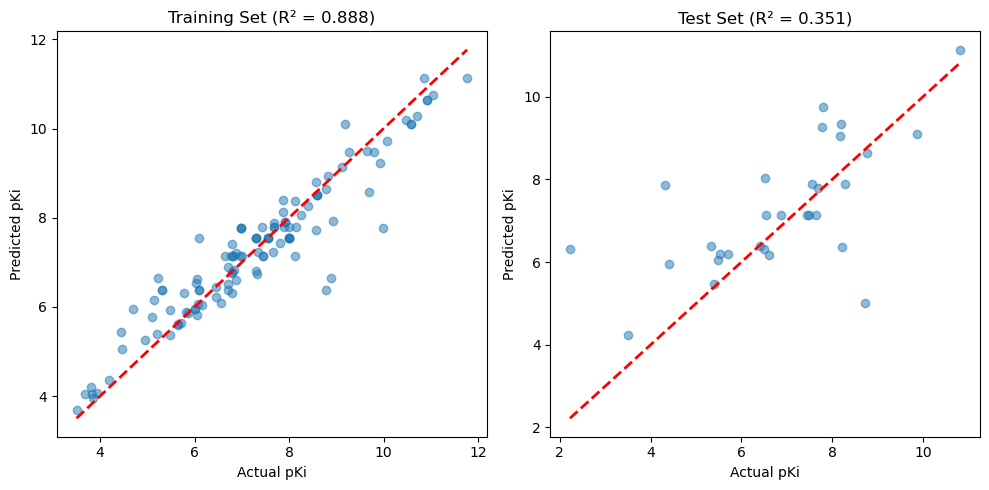

In [12]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual pKi')
plt.ylabel('Predicted pKi')
plt.title(f'Training Set (R² = {train_r2:.3f})')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pKi')
plt.ylabel('Predicted pKi')
plt.title(f'Test Set (R² = {test_r2:.3f})')

plt.tight_layout()
plt.show()



Feature Importance:
       Feature  Importance
1        alogp    0.500579
4          psa    0.155892
0  mw_freebase    0.141513
5          rtb    0.070765
3          hbd    0.068643
2          hba    0.062607


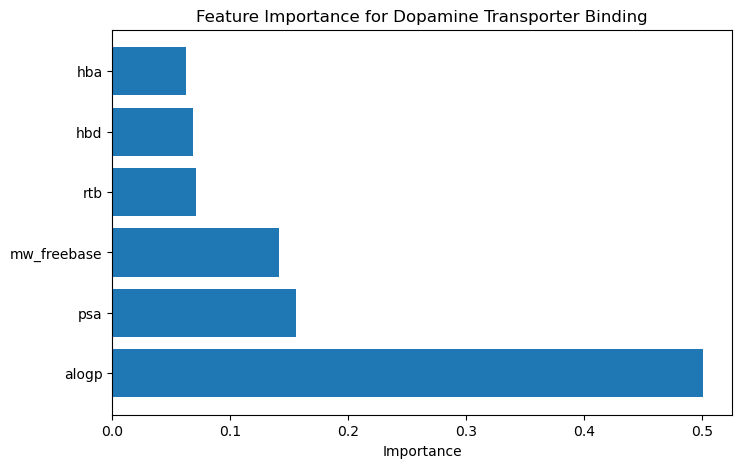

In [13]:
# Check which molecular properties are most important
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Dopamine Transporter Binding')
plt.show()


In [14]:
# Save the dataset and results
ml_data.to_csv('dopamine_transporter_data.csv', index=False)
print("Dataset saved as 'dopamine_transporter_data.csv'")

# Save model predictions
results_df = pd.DataFrame({
    'Actual_pKi': y_test,
    'Predicted_pKi': y_pred_test,
    'Compound_ID': ml_data.loc[X_test.index, 'molecule_chembl_id']
})
results_df.to_csv('predictions.csv', index=False)
print("Predictions saved as 'predictions.csv'")


Dataset saved as 'dopamine_transporter_data.csv'
Predictions saved as 'predictions.csv'
